# Coursework 1: Learning Learning, From Scratch

_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Sanjeev Muralikrishnan, Remy Sabathier & Maria Stamatopoulou__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission instructions:

Coursework submissions must comprise of a zipped folder. Inside this zip, you should have two things.


1.   This Jupyter notebook, containing your code and written comments.
2.   A "models/" folder, containing your trained model weights.


 In the notebook, cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks, these blocks are for TAs.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): PCA (12 points)

[Question 3](#question3): Linear Classification (18 points)

[Question 4](#question4): Image Denoising (30 points)

[Question 5](#question5): Neural Implicit Representation (30 points)

## Datasets

We will be using several datasets for the coursework: _IRIS_ , _MNIST_ , _CelebA_ , _NoisyOCR_.

_IRIS_ and _MNIST_ datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

_CelebA_ and _NoisyOCR_ are provided separately in a zip file; make sure to unzip it and the unzipped folder is placed in the same directory as the notebook.


**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits.

**_CelebA_**: _CelebA_ is a dataset composed of
RGB images of human faces.

**_NoisyOCR_**: _NoisyOCR_ is a dataset composed of
images of noisy OCR scans, along with corresponding clean target images.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

## Instructions for the other datasets zip file:
**Download Link:** https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip

You can download this zip locally, unzip it and keep the folder in the same directory as your Notebook. There is code provided below to download and unzip it. If you're using Colab, the downloaded content will remain only while the session is active. When you start a new session, you'd have to download it again.

**Google Drive:** For a more permanent solution, you can upload the *unzipped* folder to your own Google Drive, and mount your drive in the notebook. Code is provided below, to mount the drive.

You can use either options, and a variable `drive_mount` is provided to toggle between the two. Set this variable accordingly.

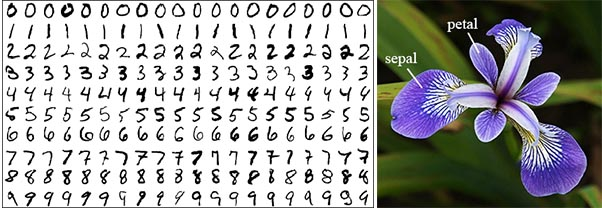

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random
import os

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split
from pathlib import Path

import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import imageio
from PIL import Image
import cv2

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from IPython.display import Video

%matplotlib inline

The following code imports the drive module from Colab. This code will only run on Colab. If you're not using Colab, comment this code out, or don't run this cell.

In [2]:
# from google.colab import drive

#Unmount any previously mounted drive if needed.
#Feel free to uncomment below line when you need to unmount Drive

#drive.flush_and_unmount()

The following cell sets the `drive_mount` variable. Set it to `True` if your Dataset folder is on drive. If you plan to use the Dataset folder locally, then set this to `False`

In [3]:
drive_mount = False

In [4]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test


#end_test




## Data Loading

The following cells are used to load IRIS and MNIST datasets.

In [5]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [6]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [7]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [8]:
def plot_eigenvecs(stacked_images, n_rows, n_columns, img_shape=None, channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)
        if channels == 1:
            # Normalize eigen vector to [0, 255] range
            eigenvector = stacked_images[i] - np.min(stacked_images[i])
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(np.reshape(eigenvector, [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray')
        elif channels == 3:
            # Normalize eigen vector to [0, 255] range for each channel
            eigenvector = stacked_images[i].reshape(img_shape[0], img_shape[1], 3)
            eigenvector -= np.min(eigenvector)
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(eigenvector)
        plt.axis('off')
    plt.show()

def plot_images(stacked_images, n_rows, n_columns, titles, num_channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)

        if num_channels == 1:
            # Grayscale image
            plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        elif num_channels == 3:
            # RGB image
            image = np.reshape(stacked_images[i], [int(np.sqrt(n_dims // 3)), int(np.sqrt(n_dims // 3)), 3])
            image = np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1] range
            plt.imshow(image)
        else:
            raise ValueError("Unsupported number of channels. Use num_channels=1 for grayscale or num_channels=3 for RGB.")

        plt.axis('off')

        if len(titles) == n_rows * n_columns:
            plt.title(titles[i])

    plt.show()

def plot_images_with_text(images, titles, texts=None):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))

    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])

    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()



In [9]:
def plot_images_horizontal(imgs):
    num_imgs = len(imgs)
    f = plt.figure(figsize=(40, 15))
    for i in range(num_imgs):
        f.add_subplot(1, num_imgs, i+1)
        plt.imshow(imgs[i])
    plt.show()

In [10]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [11]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ **dataset**

In [12]:
# X, Y = load_mnist_dataset(num_classes=10)
# X = X / 255.0
# X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

**Code for handling the Dataset zip file**

The following cell mounts your drive if `drive_mount` is `True`

In [13]:
# if drive_mount:
#   drive.mount('/content/drive')

Set `dataset_path` to Drive or local directory. Also load the CelebA dataset for PCA

In [14]:
if drive_mount:
  dataset_path = '/content/drive/MyDrive/cw_datasets/'
  assert(os.path.exists(dataset_path))
  # Set this path to your appropriate drive path
else:
  dataset_path = "./cw_datasets"
  # In this case, the datasets path is assumed to be in the same directory as this notebook

  if not os.path.exists("./cw_datasets"):
    !wget https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip
    !unzip -q -o cw_datasets.zip

def load_face_images_array(dataset_path="./cw_datasets/",test_fraction=0.05):
  images_path = os.path.join(dataset_path,"face_pca/")
  flattened_images_list = []
  images_paths = [os.path.join(images_path,p) for p in os.listdir(images_path) if p.endswith(".jpg")]
  for image_file in images_paths:
    image_np = np.array(Image.open(image_file))/255.0
    image_np_flattened = np.reshape(image_np,(1,-1))
    flattened_images_list.append(image_np_flattened)
  flattened_images = np.concatenate(flattened_images_list,0)
  split_at = int(len(flattened_images)*test_fraction)
  X_CelebA_test = flattened_images[:split_at]
  X_CelebA = flattened_images[split_at:]
  return X_CelebA, X_CelebA_test

X_CelebA,X_CelebA_test = load_face_images_array(dataset_path)
print(X_CelebA.shape,X_CelebA_test.shape)

(95, 3072) (5, 3072)


## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup/randomly created data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1a**
<a name='question1a'></a>

Implement the nsolve function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    """
    #begin_solution
    from numpy import matmul
    from numpy.linalg import inv
    w = matmul(inv(matmul(X.T,X)),X.T.dot(y) )
    #end_solution

    return w

Testing your code on mockup/randomly created data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

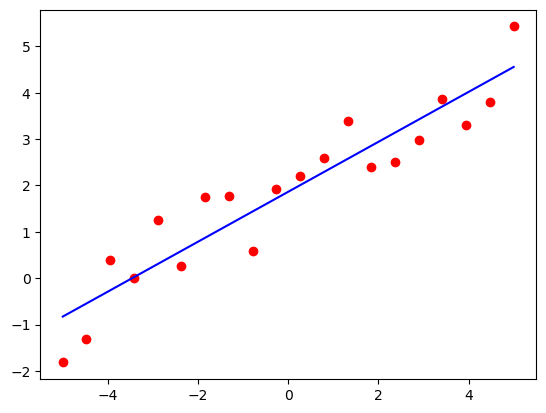

In [16]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
from numpy.random import rand
noise_marigin = 2
w = rand(2,1)
x = np.linspace(-5,5,20)
y = w[0] + w[1]*x + noise_marigin*rand((len(x)))
X = np.column_stack([np.ones([len(x),1]),x.reshape(-1,1)])
w = nsolve(X,y)
y_estimation = w[0] + w[1]*x

plt.scatter(x,y,color="red")
plt.plot(x,y_estimation,color = "blue")
plt.show()
#end_solution


**Question 1b**
<a name='question1b'></a>

Implement the line_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [17]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution
    X = np.c_[np.ones(X.shape[0]), X]
    w = nsolve(X, y)
    y_pred = X @ w
    l2_error = np.sum((y - y_pred) ** 2)**0.5
    return w, l2_error

    #end_solution


Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [18]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
iris_x = X_iris[:,[0,1,3]]
iris_y = X_iris[:,[2]]
w, l2_error = line_fit(iris_x,iris_y)
print("L2 loss on the training set:", l2_error)

#end_solution


L2 loss on the training set: 3.534583205431445


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
iris_x_test = X_iris_test[:,[0,1,3]]
iris_y_test = X_iris_test[:,[2]]

X_test = np.c_[np.ones(iris_x_test.shape[0]), iris_x_test]
Y_iris_test_pred = X_test @ w

l2_loss_test = np.sum((iris_y_test - Y_iris_test_pred) ** 2)**0.5

print("L2 loss on the test set:", l2_loss_test)


#end_solution


L2 loss on the test set: 1.5611901785495277


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

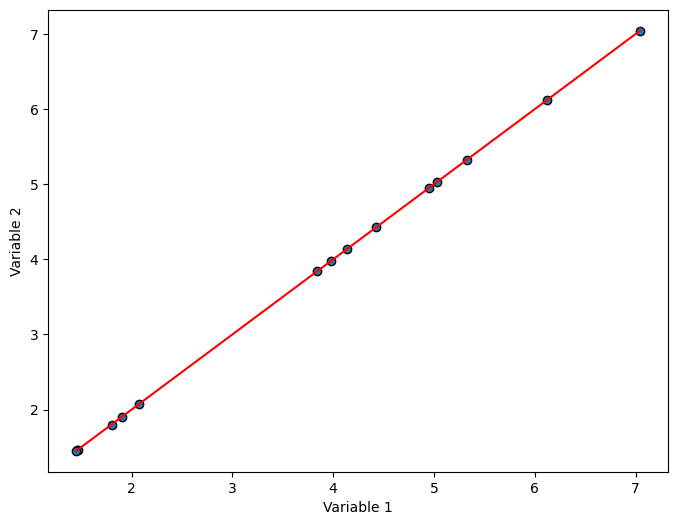

In [20]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
# plt.scatter(iris_y_test,Y_iris_test_pred)
# plt.plot(Y_iris_test_pred,Y_iris_test_pred, color = 'red', label='Perfect Prediction')
# plt.xlabel('True Petal Length (cm)')
# plt.ylabel('Predictions Petal Length (cm)')
# plt.title('Correlation (True Values vs. Predictions)')
# plt.legend()
# plt.show()
plot_correlation(Y_iris_test_pred,Y_iris_test_pred)

#end_solution


Do not write anything in the cell below, it is for TAs

In [21]:
#begin_test


#end_test



**Question 1c**
<a name='question1c'></a>

Implement the poly_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [22]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution
    def get_feature_matrix(X):
        num_samples, num_features = X.shape
        X_modified = np.zeros((num_samples, num_features * (num_features + 1) // 2))
        
        col = 0
        for i in range(num_features):
            for j in range(i, num_features):
                X_modified[:, col] = X[:, i] * X[:, j]
                col += 1
        X_modified = np.column_stack([X_modified,X])

        return X_modified
    
    X_poly = np.column_stack([get_feature_matrix(X),np.ones(X.shape[0])])

    w = nsolve(X_poly, y)
    y_pred = X_poly @ w
    l2_error = np.sum((y - y_pred) ** 2)**0.5
    return w, l2_error

    # return w, l2_error
    #end_solution

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [23]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
iris_x = X_iris[:,[0,1,2]]    
iris_y = X_iris[:,[3]]
w,l2 = poly_fit(iris_x,iris_y)

print(f"L2 error with respect to training set: {l2}")
#end_solution



L2 error with respect to training set: 2.0450366857110582


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [24]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
iris_x_test = X_iris_test[:,[0,1,2]]
iris_y_test = X_iris_test[:,[3]]

num_samples, num_features = iris_x_test.shape
X_modified = np.zeros((num_samples, num_features * (num_features + 1) // 2))

col = 0
for i in range(num_features):
    for j in range(i, num_features):
        X_modified[:, col] = iris_x_test[:, i] * iris_x_test[:, j]
        col += 1
X_modified = np.column_stack([X_modified,iris_x_test,np.ones(X_modified.shape[0])])

# print(X_modified)
Y_iris_test_pred = X_modified @ w

l2_loss_test = np.sum((iris_y_test - Y_iris_test_pred) ** 2)**0.5

print("L2 loss on the test set:", l2_loss_test)

#end_solution


L2 loss on the test set: 0.8621833315472655


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

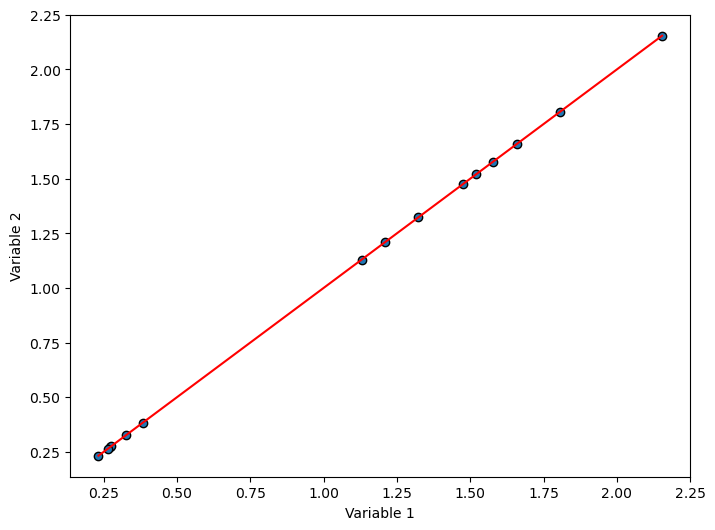

In [25]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
# plt.scatter(iris_y_test,Y_iris_test_pred)
# plt.plot(Y_iris_test_pred,Y_iris_test_pred, color = 'red', label='Perfect Prediction')
# plt.xlabel('True Petal Width (cm)')
# plt.ylabel('Predictions Petal Width (cm)')
# plt.title('Correlation (True Values vs. Predictions)')
# plt.legend()
# plt.show()
plot_correlation(Y_iris_test_pred,Y_iris_test_pred)
#end_solution


Do not write anything the cell below, it is for TAs

In [26]:
#begin_test


#end_test



## 2. PCA (12 points)
<a name='question2'></a>

[a)](#question2a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset (which is composed of 10 digit classes) and on the _CELEBA_ dataset (which contains face RGB images). Display the top 10 components fitted on the train dataset as images.(**2 points** + **2 points** + **2 points**)

[b)](#question2b) Next, check that you can reconstruct perfectly an input image (digit or face) from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**2 points** + **2 points** + **2 points** on hidden dataset)

**Question 2a**
<a name='question2a'></a>

Implement PCA and plot Eigenvectors

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [27]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

In [28]:
def pca(X, ndims, num_image_channels=1):
    """
    Compute PCA on a batch of flattened grayscale or RGB images with dynamic dimensions.

    Arguments:
    X : Data matrix where each row is a flattened image
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    mean_vec = np.mean(X,axis=0)
    covariance_matrix = (X- mean_vec).T.dot((X-mean_vec)) / (X.shape[0]-1)
    matU, sigma, matV = np.linalg.svd(covariance_matrix)
    top_eig_vecs = matU[:,:ndims]
    eigen_value = sigma[:ndims]
    #end_solution
    return mean_vec, top_eig_vecs, eigen_value


Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

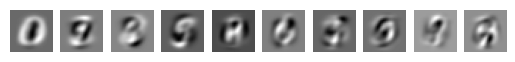

In [29]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.

Use the plot_eigenvecs function provided above.
Read that function and pass arguments as needed.
"""

#begin_solution
mean_vec, top_eig_vecs, sigma = pca(X_mnist,10)
plot_eigenvecs(top_eig_vecs.T,1,10)
# plot_eigenvecs(top_eig_vecs,1,1)
#end_solution


Testing your code on _CelebA_

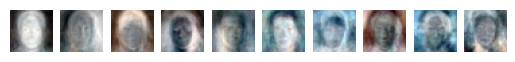

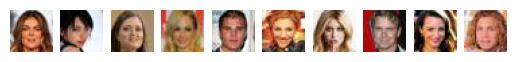

In [144]:
"""
Below, test your PCA on  CelebA dataset.
Plot and display the selected eigen vectors returned by PCA.

Use the plot_eigenvecs function provided above.
Read that function and pass arguments as needed.
"""

#begin_solution
mean_vec, top_eig_vecs, sigma = pca(X_CelebA,10)
plot_eigenvecs(top_eig_vecs.T,1,10,img_shape= [32,32],channels=3)
#end_solution


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



**Question 2b**

Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [146]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """
    #begin_solution
    centered_data = X - mean_vec
    weights = np.dot(centered_data, eig_vecs)
    #end_solution
    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [147]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution
    reconstruction = np.dot(weights, eig_vecs.T) + mean_vec
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

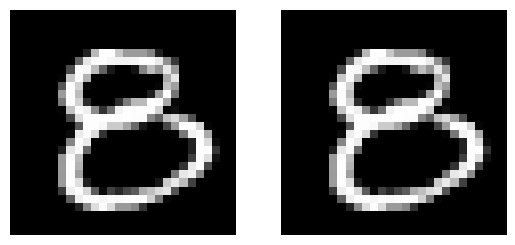

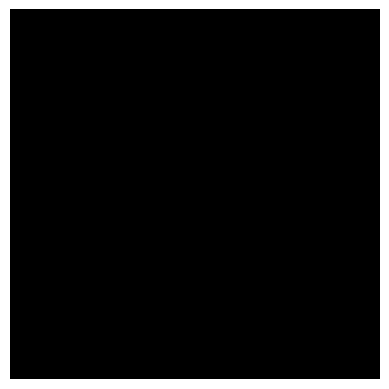

In [150]:
"""
Below,
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
mean_vec, eig_vecs, sigma = pca(X_mnist,X_mnist.shape[0])
image = X_mnist[:1,:]
weight = pca_projection(image,mean_vec,eig_vecs)
re_image = pca_reconstruction(weight,mean_vec,eig_vecs)
combined = np.row_stack([image,re_image])
plot_images(combined,1,2,"Origninal and Reconstructed")
difference = image - re_image
plot_images(difference,1,1,"Difference")
#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

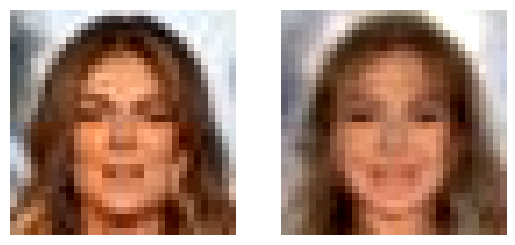

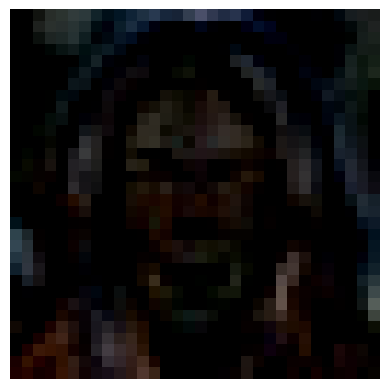

In [153]:
"""
Below,
1. Perform  PCA on CelebA training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
mean_vec, eig_vecs, sigma = pca(X_CelebA,X_CelebA.shape[0])
image = X_CelebA[:1,:]
weight = pca_projection(image,mean_vec,eig_vecs)
re_image = pca_reconstruction(weight,mean_vec,eig_vecs)
combined = np.row_stack([image,re_image])
plot_images(combined,1,2,"Origninal and Reconstructed",3)
difference = image - re_image
plot_images(difference,1,1,"Difference",3)
#end_solution


#### If your PCA reconstruction for faces is imperfect, discuss why that is the case. Edit the cell below with "Your reply" ####

_Your reply here:_ It is perfect.

Don't write anything in the block below, its for TAs

In [ ]:
#begin_test


#end_test



## 3. Linear Classification (18 points)
<a name='question3'></a>

[a)](#question3a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, and plot the confusion matrix. (**4 points** on hidden dataset)

[b)](#question3b) Extend the implementation in 3a to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)

Present findings applying multi-class classification on _IRIS_ dataset with 3 classes.

**Question 3a**
<a name='question3a'></a>

Implement Linear, binary classifier and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution

    #end_solution


    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, plot and display the confusion matrix of your prediction with respect to
true values. Use provided functions for plotting.
"""

#begin_solution

#end_solution


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



**Question 3b**
<a name='question3b'></a>

Implement Linear, multi-class classifier and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution

  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """

    #begin_solution

    #end_solution


    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution

    #end_solution


    return preds_prob

Print the accuracy of the prediction below

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



## 4. Denoising (30 points)
<a name='question4'></a>

[a)](#question4a) Implement `denoiseGauss(image)` to denoise the image `noisy_image.png` under `cw_datasets/Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question4b) Implement a convolutional neural network in Pytorch to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `cw_datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The network should have sufficient depth and complexity to be able to converge well.  Please use ReLU non-linearities after each layer (**20 points**).

[c)](#question4c) Given the comparison between the Gaussian-kernel denoising and the neural network denoising
methods, discuss which method performs better and why. You should write no more than 5 sentences. (**5 points**)


**Question 4a**
<a name='question4a'></a>

Implement the below functions to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def gkern(l=5, sig=1.):

    #begin_solution

    #end_solution


    return out_kernel

def denoise_gauss(image):

    #begin_solution

    #end_solution


    return denoised_image

Load input image from file

In [ ]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

noisy_image_filename = os.path.join(dataset_path,"Filtering/noisy_image.png")

Filter the input image

In [ ]:
noisy_image = np.asarray(Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image)
plot_images_horizontal([noisy_image, denoised_image])

**Question 4b**
<a name='question4b'></a>

Implement a neural denoiser using Pytorch

Implement dataset class below. Note that the images output by the `DenoisingDB` dataset should be of size 128 x 128. Crop the original images at the top left corner to get the aforementioned size.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingDB(Dataset):

    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()

        #begin_solution

        #end_solution


    def __len__(self):
        #begin_solution

        #end_solution

        return length

    def __getitem__(self, idx):

        #begin_solution

        #end_solution


        return (input_img, cleaned_img)


Implement the Denoising network:

Note that the network need to be sufficiently complex for performing the denoising task successfully. Feel free to experiment with different layers, blocks and operations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        #begin_solution

        #end_solution


    def forward(self, x):

        #begin_solution

        #end_solution


        return x

# Create an instance of the network
model = DenoisingCNN()


Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss_function(prediction, target):
    """
    Calculate the Mean Squared Error (MSE) loss between the prediction and the target.

    Arguments:
    prediction : torch.Tensor
        The predicted image.
    target : torch.Tensor
        The target image for reconstruction.

    Returns:
    loss : torch.Tensor
        The computed loss.
    """

    #begin_solution

    #end_solution


    return loss


Paths to input data

In [ ]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

input_imgs_path = os.path.join(dataset_path,"Denoising/input_noisy_images/")
cleaned_imgs_path = os.path.join(dataset_path,"Denoising/target_clean_images/")

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution





Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"denoiser":denoiser}, "models/denoiser.pth")

Load trained model

In [ ]:
state_dict = torch.load("models/denoiser.pth")
denoiser = state_dict["denoiser"].to(device)

Plot 5 input images and their relative denoised images side by side. Populate the 3 lists of input, gt and output with 5 images each.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
input_imgs, gt_imgs, output_imgs = [], [], []

#begin_solution

#end_solution


titles = ['Input', 'GroundTruth', 'Output']
plot_images_with_text([input_imgs, gt_imgs, output_imgs],titles,texts=None)


Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [dataset[i][0].to(device) for i in range(5)]
targets = [dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#begin_solution

#end_solution


Now we plot images and PSNR, to compare the two methods

In [ ]:
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

In [ ]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images_with_text(img, titles, texts)
plt.show()

**Question 4c**
<a name="question4c"></a>

#### Discuss which method performs better, and why, edit the cell below with "Your reply" ####

_Your reply here:_

## 5. Implicit Neural Representation (30 points)
The objective here is to learn an implicit neural function to predict frames of an animated 2D object. That is, learn a function $f(x,y,t; \theta)$, where $\theta$ are learnable MLP weights, that takes as input pixel coordinates $x,y$ and time $t$ and predicts the pixel value at that location and time. The learned function should then be able to generate frames of the video at any given instance $t$. The task is divided into multiple incremental blocks as below:

[a)](#question5a) Fit an MLP model to a _single_ image. **(5 points)**

[b)](#question5b) Add positional encoding of pixels to improve prediction. **(5 points)**

[c)](#question5c) Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. **(8 points)**

[d)](#question5d) Fit the MLP to the sequence of frames with and without positional encoding on time, and report the result for both **(2 points)**

[e)](#question5e) Implement batching, to prevent memory issues when evaluating large number of pixels with the MLP. Size of a batch should not exceed 16000 **(5 points)**

[f)](#question5f) Generate a video of 100 frames uniformly sampled between the first and last frame. Since you trained on only 11 frames, by generating 100 frames you're interpolating unseen video frames. If your method works correctly, it should produce a continuous motion. If you overfit on the training frames, then it would give a discontinuous or jagged motion **(5 points)**


**Let's Prepare the animation inputs**

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/0/07/The_Horse_in_Motion-anim.gif'

X = np.zeros((11,230,340),dtype=np.uint8)
with imageio.get_reader('The_Horse_in_Motion-anim.gif') as r:
    for i in range(11):
        X[i] = r.get_data(i)
        X[i,0:20] = 255
        X[i,200:] = 255
        X[i,:,300:] = 255
        X[i,:,:10] = 255

X_resized = np.stack([cv2.resize(X[k], (128,128), cv2.INTER_AREA) for k in range(X.shape[0])], axis=0)
for i in range(X_resized.shape[0]):
  X_resized[i] = np.where(X_resized[i]>60,0,1)

Let's visualize the frames:

In [ ]:
plt.figure(figsize=(6*3,2*3))
for i in range(11):
    plt.subplot(2,6,i+1)
    plt.imshow(X_resized[i])
    plt.title(f'Frame {i}')
plt.show()
plt.close()

Save the frames as a video sequence

In [ ]:
output_path = 'input_bw_video.mp4'
with imageio.get_writer(output_path, mode='I', fps=10) as writer:
        for k in range(X_resized.shape[0]):
            writer.append_data(255*X_resized[k])
Video(output_path)

Visualization util method

In [ ]:
def plot_implicit_representation_single_image(image, model, device='cuda'):

    '''
    Visualize implicit representation of image from training the MLP model

    Args:
        - image TORCHFLOAT32 (H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_image(image, model, device='cuda')
    U = U.reshape((1,image.shape[0],image.shape[1]))
    U_bw = (U>0.5).type(torch.int32).cpu()

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.title('Implicit rep.')
    plt.imshow(U[0].cpu().numpy())
    plt.colorbar()
    plt.clim(0,1)

    plt.subplot(1,3,2)
    plt.imshow(U_bw[0].cpu().numpy())
    plt.title('Prediction')

    plt.subplot(1,3,3)
    plt.imshow(image.cpu())
    plt.title('Ground truth')

def plot_implicit_representation_multi_images(images, model, device='cuda'):

    '''
    Visualize implicit representation of a set of images from training the MLP model

    Args:
        - images TORCHFLOAT32 (N,H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_images(images, model, device='cuda')
    U = U.reshape((images.shape[0],images.shape[1],images.shape[2])).cpu()
    U_bw = (U>0.5).type(torch.int32).cpu()

    for i in range(images.shape[0]):

        plt.figure(figsize=(12,6))

        plt.subplot(1,3,1)
        plt.title('Implicit rep.')
        plt.imshow(U[i].cpu().numpy())
        plt.colorbar()
        plt.clim(0,1)

        plt.subplot(1,3,2)
        plt.imshow(U_bw[i].cpu().numpy())
        plt.title('Prediction')

        plt.subplot(1,3,3)
        plt.imshow(images[i].cpu())
        plt.title(f'Ground truth Frame {i}')

def plot_loss_and_accuracy(loss_list,accuracy_list):
    plt.figure(figsize=(8*2,6))

    plt.subplot(1,2,1)
    plt.plot([x[0] for x in loss_list], [x[1] for x in loss_list])
    plt.title('Training loss')
    plt.xlabel('epochs')

    plt.subplot(1,2,2)
    plt.plot([x[0] for x in accuracy_list], [x[1] for x in accuracy_list])
    plt.title('Accuracy')
    plt.ylim(0.,1.)
    plt.xlabel('epochs')

**Question 5a**
<a name='question5a'></a>

Fit an MLP model to a single image

Below, write a MLP model which takes as input a pixel position (x,y) and return a pixel value prediction $p_{x,y}$

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        #begin_solution

        #end_solution


    def forward(self, input):
        #begin_solution

        #end_solution

        return prediction

Write a function which samples random pixel positions in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Sample random pixel positions
def sample_image(image, n, scaled=True):
  '''
  Args:
    - image TORCHINT32 (H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,2)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution

  #end_solution


  return sampled_positions, pixel_values

Write a function that takes and image and a trained MLP and predicts all pixel values of the image. That is, for every $x,y$ in the given image, predict its pixel value with the MLP.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_image(image, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
  Return:
    - prediction TORCHFLOAT32 (H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction

Write a function to evaluate the model's prediction performance

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_accuracy(image, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
  Return:
    - mean_accuracy FLOAT32
  '''

  #begin_solution

  #end_solution


  return accuracy

Write the training loop. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image.pth")
model = state_dict["model"].to(device)

Let's plot our performance

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device='cuda')

**Question 5b**
<a name='question5b'></a>

Add positional encoding of pixels to improve predictions.

Write a function that positionally encodes the input.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi):
    #begin_solution

    #end_solution

    return torch.cat([cos_encoding,sin_encoding], axis=-1)

Write a new MLP, while reusing the previous MLP model, that can predict using the positionally encoded pixel locations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE(nn.Module):
    '''
    MLP with positional encoding class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension, positional_enc_L=0):
        super(MLP_PE, self).__init__()
        #begin_solution

        #end_solution


    def forward(self, input):

        #begin_solution

        #end_solution


        return prediction

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image_positional_encoding.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image_positional_encoding.pth")
model = state_dict["model"].to(device)

Let's plot our performance.

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device='cuda')

**Question 5c**
<a name='question5c'></a>

Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. You'd need to rewrite image sampling and other functions to achieve this.

Write a function that can now also sample across the time dimension.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def sample_images(images, n, scaled=True):
  '''
  Args:
    - images TORCHINT32 (N_frames, H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,3)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution

  #end_solution

  return sampled_positions, pixel_values


Write a function to predict the images, now also across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction

Write a function to evaluate performance across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_mean_accuracy(images, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - mean_accuracy FLOAT32
  '''
  #begin_solution

  #end_solution


  return accuracy

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_images_sequence.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_images_sequence.pth")
model = state_dict["model"].to(device)

Let's plot our performance

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_multi_images(images, model, device='cuda')

**Question 5d**
<a name='question5d'></a>

Apply positional encoding for the time dimension.

Write a function that positionally encodes time values, with an optional flag to enable or disable it.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi, encode_time_dimension=True):
    #begin_solution

    #end_solution

    return encoding

Write a new MLP, while re-using the previous one, that now predicts using the positionally encoded time. It should also predict without positional encoding, for comparison.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE_time_option(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension,
                 positional_enc_L=0,encode_time_dimension=True):
        super(MLP_PE_time_option, self).__init__()
        #begin_solution

        #end_solution


    def forward(self, input):
        #begin_solution

        #end_solution

        return prediction


Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list. These lists can be used for plotting later.

Note that this time, the two lists are nested. Each list should contain two sub-lists, one with Positional Encoding turned ON and other with Positional Encoding turned oFF. Each sub-list, similar to before, has scalar loss/acurracy values in each epoch.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [[],[]], [[],[]]

# Assign your model to these variables depending on whether they have time encoding or not.
# We'll save these models to disk later
mlp_model_with_time_encoding = None
mlp_model_without_time_encoding = None

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":mlp_model_with_time_encoding}, "models/implicit_images_sequence_with_time_encoding.pth")
torch.save({"model":mlp_model_without_time_encoding}, "models/implicit_images_sequence_without_time_encoding.pth")

Let's plot both accuracies and loss curves.

In [ ]:
plt.figure(figsize=(8*2,6))

plt.subplot(1,2,1)
plt.plot([x[0] for x in loss_list[0]], [x[1] for x in loss_list[0]], label='With time encoding')
plt.plot([x[0] for x in loss_list[1]], [x[1] for x in loss_list[1]], label='Without time encoding')
plt.title('Training loss')
plt.legend()
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot([x[0] for x in accuracy_list[0]], [x[1] for x in accuracy_list[0]], label='With time encoding')
plt.plot([x[0] for x in accuracy_list[1]], [x[1] for x in accuracy_list[1]], label='Without time encoding')
plt.title('Accuracy')
plt.ylim(0.,1.)
plt.xlabel('epochs')
plt.legend()

print('Accuracy with time encoding : {:.3f} without: {:.3f}'.format(accuracy_list[0][-1][1],accuracy_list[1][-1][1]))

**Question 5e**
<a name='question5e'></a>

Implement batching to prevent memory issues when evaluating large number of pixels with the MLP. Batch size should not exceed 16000.

Write a partition indexing function to create a list of partition indices that can be used to split the input into equal size chunks for prediction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def partition_index(totalsize, chunksize):
    '''
    Args:
        - totalsize: int, Size of the batch to process
        - chunksize: int, subdivision to apply
    Return:
        - list_tuples: List, List of tuples (i,j) to process the batch in equal chunk
    '''
    #begin_solution

    #end_solution

    return list_tuples

Update image prediction to use the implemented batch partitioning

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction


**Question 5f**
<a name='question5f'></a>

Write code to generate a video of 100 frames uniformly sampled between the first and last frame. Save the video as an MP4.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
output_path = 'result_bw_video.mp4'
#begin_solution

#end_solution

Video(output_path)